<a href="https://colab.research.google.com/github/JoshuaDePasquale/DA-experiments/blob/main/Ecology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECOLOGICAL FOOD WEB DECOMPOSABILITY ANALYSIS
STAGE 1: Ecological Network Construction
--------------------------------------------------

Processing: pelagic_web
Citation: Polis & Strong (1996) Am Nat 147:813-846; Post (2002) Trends Ecol Evol 17:269-277

Processing: terrestrial_web
Citation: Pimm et al. (1991) Nature 350:669-674; Williams & Martinez (2000) Nature 404:180-183

Processing: stream_web
Citation: Wallace & Webster (1996) J N Am Benthol Soc 15:115-132; Woodward et al. (2005) Trends Ecol Evol 20:402-409

Processing: soil_web
Citation: Moore & Hunt (1988) Biol Fertil Soils 6:1-9; de Ruiter et al. (1995) Science 269:1257-1260

Constructed food web with 38 species and 65 trophic links
Food web modules: ['pelagic_web', 'terrestrial_web', 'stream_web', 'soil_web']
Trophic levels present: [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]

STAGE 2: Ecological State Function
--------------------------------------------------
Ecological State S(X):
  energy_flow_efficiency: 0.0668
  trophic_coherence:

/tmp/ipython-input-3-2357921688.py:781: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()



Visualization saved as 'ecological_decomposability_analysis.png'


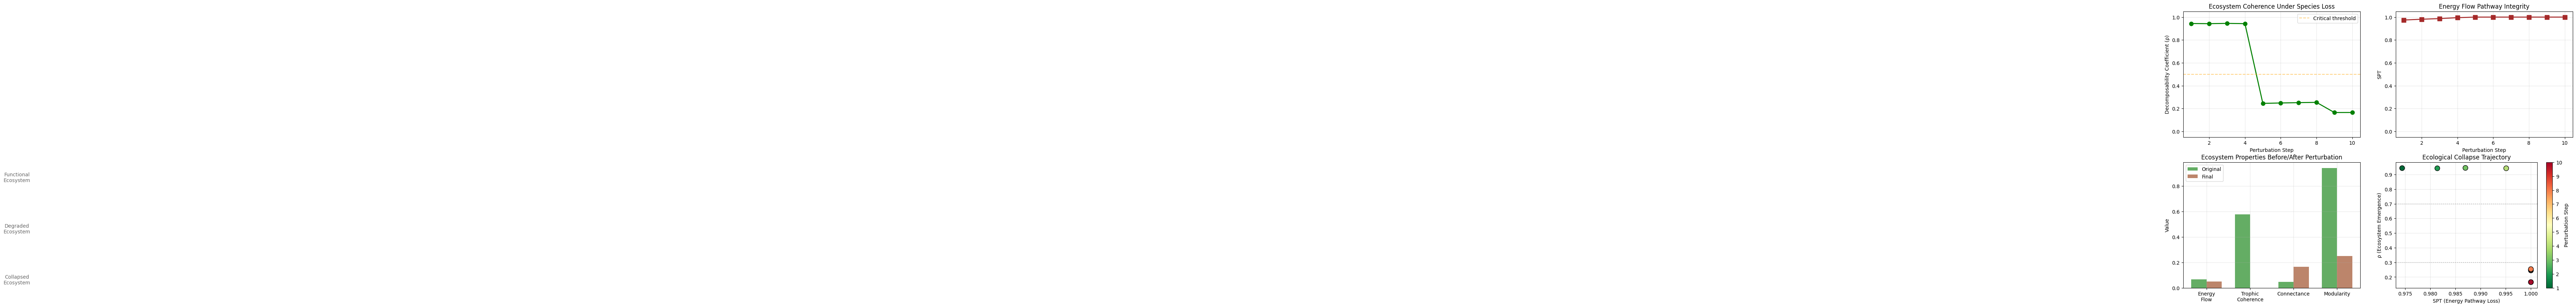

In [3]:
import numpy as np
import networkx as nx
from collections import defaultdict
from scipy.stats import entropy
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set, Optional
import itertools

class EcologicalDecomposability:
    """
    Implementation of decomposability framework for ecological food webs.
    Based on empirically documented trophic interactions from ecological literature.
    """

    def __init__(self):
        # Well-documented food web modules from ecological literature
        self.ecological_networks = {
            "pelagic_web": {
                "species": [
                    # Marine pelagic food web (Polis & Strong, 1996; Post, 2002)
                    ("phytoplankton", "primary_producer", 1),
                    ("zooplankton", "primary_consumer", 2),
                    ("small_fish", "secondary_consumer", 3),
                    ("large_fish", "tertiary_consumer", 4),
                    ("squid", "secondary_consumer", 3),
                    ("seabirds", "top_predator", 4.5),
                    ("marine_bacteria", "decomposer", 1),
                    ("detritus", "detrital_pool", 1),
                ],
                "interactions": [
                    # Format: (prey, predator, interaction_strength, energy_transfer)
                    ("phytoplankton", "zooplankton", 0.9, 0.1),
                    ("phytoplankton", "small_fish", 0.3, 0.1),  # Some fish are herbivorous
                    ("zooplankton", "small_fish", 0.8, 0.1),
                    ("zooplankton", "squid", 0.6, 0.1),
                    ("small_fish", "large_fish", 0.9, 0.1),
                    ("small_fish", "seabirds", 0.7, 0.1),
                    ("squid", "large_fish", 0.5, 0.1),
                    ("squid", "seabirds", 0.4, 0.1),
                    ("large_fish", "seabirds", 0.3, 0.1),
                    # Detrital pathways
                    ("phytoplankton", "detritus", 0.2, 0.9),  # Death
                    ("zooplankton", "detritus", 0.2, 0.9),
                    ("detritus", "marine_bacteria", 0.9, 0.1),
                    ("marine_bacteria", "zooplankton", 0.4, 0.1),  # Microbial loop
                ],
                "citation": "Polis & Strong (1996) Am Nat 147:813-846; Post (2002) Trends Ecol Evol 17:269-277"
            },

            "terrestrial_web": {
                "species": [
                    # Terrestrial grassland web (Pimm et al., 1991; Williams & Martinez, 2000)
                    ("grasses", "primary_producer", 1),
                    ("herbs", "primary_producer", 1),
                    ("grasshoppers", "herbivore", 2),
                    ("caterpillars", "herbivore", 2),
                    ("mice", "omnivore", 2.5),
                    ("rabbits", "herbivore", 2),
                    ("spiders", "secondary_consumer", 3),
                    ("songbirds", "omnivore", 3),
                    ("snakes", "tertiary_consumer", 3.5),
                    ("hawks", "apex_predator", 4),
                    ("soil_bacteria", "decomposer", 1),
                    ("fungi", "decomposer", 1),
                ],
                "interactions": [
                    ("grasses", "grasshoppers", 0.8, 0.1),
                    ("grasses", "rabbits", 0.9, 0.1),
                    ("grasses", "mice", 0.5, 0.1),
                    ("herbs", "caterpillars", 0.9, 0.1),
                    ("herbs", "rabbits", 0.6, 0.1),
                    ("herbs", "mice", 0.4, 0.1),
                    ("grasshoppers", "spiders", 0.8, 0.1),
                    ("grasshoppers", "songbirds", 0.6, 0.1),
                    ("grasshoppers", "mice", 0.3, 0.1),
                    ("caterpillars", "songbirds", 0.8, 0.1),
                    ("caterpillars", "spiders", 0.5, 0.1),
                    ("mice", "snakes", 0.8, 0.1),
                    ("mice", "hawks", 0.6, 0.1),
                    ("rabbits", "hawks", 0.7, 0.1),
                    ("songbirds", "hawks", 0.5, 0.1),
                    ("songbirds", "snakes", 0.4, 0.1),
                    ("snakes", "hawks", 0.4, 0.1),
                    ("spiders", "songbirds", 0.5, 0.1),
                    # Decomposer pathways
                    ("grasses", "soil_bacteria", 0.3, 0.9),
                    ("herbs", "fungi", 0.3, 0.9),
                    ("soil_bacteria", "fungi", 0.2, 0.1),  # Mutualism
                ],
                "citation": "Pimm et al. (1991) Nature 350:669-674; Williams & Martinez (2000) Nature 404:180-183"
            },

            "stream_web": {
                "species": [
                    # Stream food web (Wallace & Webster, 1996; Woodward et al., 2005)
                    ("algae", "primary_producer", 1),
                    ("leaf_litter", "allochthonous_input", 1),
                    ("mayflies", "scraper", 2),
                    ("caddisflies", "shredder", 2),
                    ("midges", "collector", 2),
                    ("stoneflies", "predator", 3),
                    ("trout", "top_predator", 4),
                    ("crayfish", "omnivore", 2.5),
                    ("aquatic_fungi", "decomposer", 1),
                ],
                "interactions": [
                    ("algae", "mayflies", 0.9, 0.1),
                    ("algae", "midges", 0.6, 0.1),
                    ("algae", "crayfish", 0.4, 0.1),
                    ("leaf_litter", "caddisflies", 0.9, 0.1),
                    ("leaf_litter", "crayfish", 0.5, 0.1),
                    ("leaf_litter", "aquatic_fungi", 0.8, 0.1),
                    ("aquatic_fungi", "caddisflies", 0.6, 0.1),  # Conditioning
                    ("mayflies", "stoneflies", 0.8, 0.1),
                    ("mayflies", "trout", 0.7, 0.1),
                    ("caddisflies", "stoneflies", 0.6, 0.1),
                    ("caddisflies", "trout", 0.8, 0.1),
                    ("midges", "stoneflies", 0.7, 0.1),
                    ("midges", "trout", 0.5, 0.1),
                    ("stoneflies", "trout", 0.6, 0.1),
                    ("crayfish", "trout", 0.3, 0.1),
                ],
                "citation": "Wallace & Webster (1996) J N Am Benthol Soc 15:115-132; Woodward et al. (2005) Trends Ecol Evol 20:402-409"
            },

            "soil_web": {
                "species": [
                    # Soil food web (Moore & Hunt, 1988; de Ruiter et al., 1995)
                    ("plant_roots", "primary_producer", 1),
                    ("root_exudates", "dissolved_organic_matter", 1),
                    ("bacteria", "microbivore", 1.5),
                    ("fungi", "saprophyte", 1.5),
                    ("protozoa", "microbivore", 2),
                    ("nematodes", "microbivore", 2),
                    ("springtails", "fungivore", 2),
                    ("mites", "predator", 3),
                    ("predatory_nematodes", "predator", 3),
                ],
                "interactions": [
                    ("plant_roots", "fungi", 0.6, 0.1),  # Mycorrhizae
                    ("root_exudates", "bacteria", 0.9, 0.1),
                    ("root_exudates", "fungi", 0.5, 0.1),
                    ("bacteria", "protozoa", 0.8, 0.1),
                    ("bacteria", "nematodes", 0.7, 0.1),
                    ("fungi", "springtails", 0.8, 0.1),
                    ("fungi", "nematodes", 0.4, 0.1),
                    ("protozoa", "nematodes", 0.3, 0.1),
                    ("nematodes", "mites", 0.7, 0.1),
                    ("nematodes", "predatory_nematodes", 0.8, 0.1),
                    ("springtails", "mites", 0.6, 0.1),
                    ("protozoa", "predatory_nematodes", 0.4, 0.1),
                ],
                "citation": "Moore & Hunt (1988) Biol Fertil Soils 6:1-9; de Ruiter et al. (1995) Science 269:1257-1260"
            }
        }

        self.graph = None
        self.module_boundaries = {}
        self.trophic_levels = {}

    def stage1_graph_construction(self) -> nx.DiGraph:
        """
        Stage 1: Construct directed graph from ecological food webs.
        Nodes: (species, guild, trophic_level) tuples
        Edges: Trophic interactions weighted by coupling strength
        """
        print("STAGE 1: Ecological Network Construction")
        print("-" * 50)

        G = nx.DiGraph()
        self.module_boundaries = {}
        self.trophic_levels = {}

        for web_name, web_data in self.ecological_networks.items():
            print(f"\nProcessing: {web_name}")
            print(f"Citation: {web_data['citation']}")

            # Add species nodes
            for species, guild, trophic_level in web_data["species"]:
                node = (species, guild, trophic_level)
                G.add_node(node,
                          species=species,
                          guild=guild,
                          trophic_level=trophic_level,
                          web=web_name)

                # Track module membership
                if web_name not in self.module_boundaries:
                    self.module_boundaries[web_name] = []
                self.module_boundaries[web_name].append(node)

                # Track trophic structure
                if trophic_level not in self.trophic_levels:
                    self.trophic_levels[trophic_level] = []
                self.trophic_levels[trophic_level].append(node)

            # Add trophic interactions
            for prey, predator, strength, efficiency in web_data["interactions"]:
                # Find full node tuples
                prey_node = next((n for n in G.nodes() if n[0] == prey and G.nodes[n]['web'] == web_name), None)
                predator_node = next((n for n in G.nodes() if n[0] == predator and G.nodes[n]['web'] == web_name), None)

                if prey_node and predator_node:
                    # Weight based on interaction strength and trophic efficiency
                    weight = strength * efficiency

                    G.add_edge(prey_node, predator_node,
                              weight=weight,
                              interaction_strength=strength,
                              trophic_efficiency=efficiency,
                              energy_flow=strength * efficiency)

        # Add weak inter-web connections (habitat boundaries)
        self._add_habitat_connections(G)

        print(f"\nConstructed food web with {G.number_of_nodes()} species and {G.number_of_edges()} trophic links")
        print(f"Food web modules: {list(self.module_boundaries.keys())}")
        print(f"Trophic levels present: {sorted(self.trophic_levels.keys())}")

        self.graph = G
        return G

    def _add_habitat_connections(self, G: nx.DiGraph):
        """Add realistic ecological connections between habitats."""
        habitat_connections = [
            # Terrestrial-stream connections
            (("leaf_litter", "allochthonous_input", 1), ("herbs", "primary_producer", 1),
             "detrital_input", 0.2),
            (("trout", "top_predator", 4), ("hawks", "apex_predator", 4),
             "prey_subsidy", 0.1),

            # Stream-soil connections
            (("aquatic_fungi", "decomposer", 1), ("fungi", "saprophyte", 1.5),
             "spore_dispersal", 0.1),

            # Marine-terrestrial connections (seabird guano)
            (("seabirds", "top_predator", 4.5), ("grasses", "primary_producer", 1),
             "nutrient_subsidy", 0.15),
        ]

        for source, target, connection_type, strength in habitat_connections:
            if source in G.nodes() and target in G.nodes():
                G.add_edge(source, target,
                          weight=strength * 0.1,  # Weak connections
                          interaction_strength=strength,
                          connection_type=connection_type,
                          cross_habitat=True)

    def stage2_state_function(self, G: nx.DiGraph) -> Dict[str, float]:
        """
        Stage 2: Define state function capturing ecological functionality.
        """
        print("\nSTAGE 2: Ecological State Function")
        print("-" * 50)

        state = {}

        # 1. Energy Flow Efficiency
        # Total energy transfer through trophic levels
        total_energy_flow = 0
        for u, v, data in G.edges(data=True):
            if 'energy_flow' in data:
                total_energy_flow += data['energy_flow']

        state['energy_flow_efficiency'] = total_energy_flow / (G.number_of_edges() + 1)

        # 2. Trophic Coherence
        # How well-defined are trophic levels? (Johnson et al., 2014)
        trophic_distances = []
        for u, v in G.edges():
            level_diff = abs(u[2] - v[2])
            expected_diff = 1.0  # Prey should be ~1 level below predator
            coherence = 1.0 - abs(level_diff - expected_diff)
            trophic_distances.append(coherence)

        state['trophic_coherence'] = np.mean(trophic_distances) if trophic_distances else 0

        # 3. Connectance
        # Proportion of realized links (Martinez, 1992)
        n_species = G.number_of_nodes()
        if n_species > 1:
            possible_links = n_species * (n_species - 1)
            state['connectance'] = G.number_of_edges() / possible_links
        else:
            state['connectance'] = 0

        # 4. Omnivory Index
        # Feeding on multiple trophic levels (Polis, 1991)
        omnivory_count = 0
        for predator in G.nodes():
            prey_levels = [G.nodes[prey]['trophic_level'] for prey in G.predecessors(predator)]
            if len(set(prey_levels)) > 1:
                omnivory_count += 1

        state['omnivory_index'] = omnivory_count / (n_species + 1)

        # 5. Keystone Index
        # Species with disproportionate effects (Power et al., 1996)
        # Using betweenness centrality weighted by biomass flow
        if G.number_of_nodes() > 0:
            centrality = nx.betweenness_centrality(G, weight='weight')
            centrality_values = list(centrality.values())
            # Coefficient of variation as keystoneness proxy
            if np.mean(centrality_values) > 0:
                state['keystone_index'] = np.std(centrality_values) / np.mean(centrality_values)
            else:
                state['keystone_index'] = 0
        else:
            state['keystone_index'] = 0

        # 6. Modularity
        # Compartmentalization of food web (Krause et al., 2003)
        modularity_score = 0
        for module, nodes in self.module_boundaries.items():
            # Filter to only include nodes that still exist in the graph
            existing_nodes = [n for n in nodes if n in G.nodes()]
            if len(existing_nodes) > 1:
                subgraph = G.subgraph(existing_nodes)
                internal_edges = subgraph.number_of_edges()

                # Count edges leaving module
                external_edges = 0
                for node in existing_nodes:
                    for neighbor in G.neighbors(node):
                        if neighbor not in existing_nodes:
                            external_edges += 1

                if (internal_edges + external_edges) > 0:
                    modularity_score += internal_edges / (internal_edges + external_edges)

        state['modularity'] = modularity_score / len(self.module_boundaries) if self.module_boundaries else 0

        # 7. Robustness (based on redundancy in pathways)
        redundancy_score = 0
        sampled_pairs = 0
        for trophic_level in [1, 2, 3]:
            if trophic_level in self.trophic_levels and (trophic_level + 1) in self.trophic_levels:
                # Filter to only existing species
                lower_species = [s for s in self.trophic_levels[trophic_level] if s in G.nodes()][:3]
                upper_species = [s for s in self.trophic_levels[trophic_level + 1] if s in G.nodes()][:3]

                for prey in lower_species:
                    for predator in upper_species:
                        if prey in G and predator in G:
                            try:
                                paths = list(nx.all_simple_paths(G, prey, predator, cutoff=3))
                                if len(paths) > 1:
                                    redundancy_score += 1
                                sampled_pairs += 1
                            except:
                                pass

        state['pathway_redundancy'] = redundancy_score / (sampled_pairs + 1)

        print("Ecological State S(X):")
        for key, value in state.items():
            print(f"  {key}: {value:.4f}")

        return state

    def stage3_perturbation_series(self, G: nx.DiGraph, perturbation_steps: int = 10) -> List[nx.DiGraph]:
        """
        Stage 3: Ecologically realistic perturbation series.
        Models species extinctions and habitat degradation.
        """
        print("\nSTAGE 3: Ecological Perturbation Series")
        print("-" * 50)

        perturbed_graphs = []

        for step in range(perturbation_steps):
            G_perturbed = G.copy()
            perturbation_level = (step + 1) / perturbation_steps

            # 1. Species extinction (node removal)
            # Following realistic extinction patterns
            species_to_remove = int(G.number_of_nodes() * perturbation_level * 0.3)

            # Extinction risk based on trophic level and specialization
            extinction_risk = {}
            for node in G_perturbed.nodes():
                # Higher trophic levels more vulnerable (Purvis et al., 2000)
                trophic_vulnerability = node[2] / 5.0

                # Specialists more vulnerable (McKinney, 1997)
                in_degree = G_perturbed.in_degree(node)
                out_degree = G_perturbed.out_degree(node)
                specialization = 1.0 / (1 + min(in_degree, out_degree))

                extinction_risk[node] = trophic_vulnerability * 0.6 + specialization * 0.4

            # Remove species by extinction risk
            sorted_species = sorted(extinction_risk.items(), key=lambda x: x[1], reverse=True)
            for i in range(min(species_to_remove, len(sorted_species))):
                node_to_remove = sorted_species[i][0]
                if node_to_remove in G_perturbed:
                    G_perturbed.remove_node(node_to_remove)

            # 2. Habitat degradation (edge weakening)
            edges_to_degrade = list(G_perturbed.edges(data=True))

            for u, v, data in edges_to_degrade:
                if G_perturbed.has_edge(u, v):
                    # Weak links fail first (McCann, 2000)
                    degradation_factor = 1 - (perturbation_level * (1 - data['weight']))
                    new_weight = data['weight'] * degradation_factor

                    if new_weight < 0.05:  # Functional extinction threshold
                        G_perturbed.remove_edge(u, v)
                    else:
                        G_perturbed[u][v]['weight'] = new_weight
                        G_perturbed[u][v]['energy_flow'] = new_weight

            # 3. Secondary extinctions (bottom-up and top-down)
            changes = True
            while changes:
                changes = False
                nodes_to_remove = []

                for node in list(G_perturbed.nodes()):  # Create list to avoid iteration errors
                    # Bottom-up: Species with no prey (except primary producers)
                    if node[2] > 1 and G_perturbed.in_degree(node) == 0:
                        nodes_to_remove.append(node)
                        changes = True

                    # Top-down: Isolated species with no predators or prey
                    elif G_perturbed.degree(node) == 0:
                        nodes_to_remove.append(node)
                        changes = True

                for node in nodes_to_remove:
                    if node in G_perturbed:
                        G_perturbed.remove_node(node)

            perturbed_graphs.append(G_perturbed)

            # Report ecosystem state
            if G_perturbed.number_of_nodes() > 0:
                remaining_species = G_perturbed.number_of_nodes()
                remaining_links = G_perturbed.number_of_edges()

                # Count species by trophic level
                trophic_counts = defaultdict(int)
                for node in G_perturbed.nodes():
                    trophic_counts[node[2]] += 1

                print(f"Step {step + 1}: {remaining_species}/{G.number_of_nodes()} species, "
                      f"{remaining_links}/{G.number_of_edges()} links")
                print(f"  Trophic distribution: {dict(sorted(trophic_counts.items()))}")
            else:
                print(f"Step {step + 1}: Ecosystem collapsed")

        return perturbed_graphs

    def stage4_decomposability_coefficient(self, original_state: Dict, perturbed_state: Dict) -> float:
        """
        Stage 4: Calculate decomposability coefficient for ecological systems.
        """
        # Handle missing keys
        all_keys = set(original_state.keys()) | set(perturbed_state.keys())

        original_values = np.array([original_state.get(k, 0.0) for k in sorted(all_keys)])
        perturbed_values = np.array([perturbed_state.get(k, 0.0) for k in sorted(all_keys)])

        # Handle complete collapse
        if np.sum(np.abs(original_values)) < 1e-10 or np.sum(np.abs(perturbed_values)) < 1e-10:
            return 0.0

        # Normalize to probability distributions
        original_values = np.abs(original_values)
        perturbed_values = np.abs(perturbed_values)

        original_dist = original_values / np.sum(original_values)
        perturbed_dist = perturbed_values / np.sum(perturbed_values)

        # Add epsilon
        epsilon = 1e-10
        original_dist = np.clip(original_dist, epsilon, 1.0)
        perturbed_dist = np.clip(perturbed_dist, epsilon, 1.0)

        # Renormalize
        original_dist = original_dist / np.sum(original_dist)
        perturbed_dist = perturbed_dist / np.sum(perturbed_dist)

        # KL divergence
        kl_div = entropy(perturbed_dist, original_dist)

        # Convert to decomposability coefficient
        rho = np.exp(-kl_div)

        return rho

    def stage5_metrics_derivation(self, original_graph: nx.DiGraph, perturbed_graphs: List[nx.DiGraph]) -> Dict:
        """
        Stage 5: Derive SPT and STT metrics for ecological systems.
        """
        print("\nSTAGE 5: Ecological Metric Derivation")
        print("-" * 50)

        # Calculate original state
        original_state = self.stage2_state_function(original_graph)

        # Track metrics
        rho_series = []
        spt_series = []

        for i, G_perturbed in enumerate(perturbed_graphs):
            # Decomposability coefficient
            if G_perturbed.number_of_nodes() > 0:
                perturbed_state = self.stage2_state_function(G_perturbed)
                rho = self.stage4_decomposability_coefficient(original_state, perturbed_state)
            else:
                rho = 0.0
            rho_series.append(rho)

            # SPT calculation for ecological pathways
            spt = self._calculate_ecological_spt(original_graph, G_perturbed)
            spt_series.append(spt)

        # STT determination
        stt = self._determine_stt(rho_series)

        return {
            'rho_series': rho_series,
            'spt_series': spt_series,
            'stt': stt,
            'original_state': original_state,
            'final_state': self.stage2_state_function(perturbed_graphs[-1]) if perturbed_graphs[-1].number_of_nodes() > 0 else {}
        }

    def _calculate_ecological_spt(self, G_original: nx.DiGraph, G_perturbed: nx.DiGraph) -> float:
        """
        Calculate SPT for critical energy flow pathways.
        """
        original_capacity = 0
        preserved_capacity = 0

        # Critical pathways: primary producers to top predators
        critical_pathways = []

        # Find representatives at each trophic level
        for level in sorted(self.trophic_levels.keys()):
            if level in [1, 4, 4.5]:  # Producers and top predators
                for species in self.trophic_levels[level][:2]:  # Sample
                    if species in G_original.nodes():
                        critical_pathways.append((level, species))

        # Check energy flow between trophic levels
        for i, (level1, species1) in enumerate(critical_pathways):
            for j, (level2, species2) in enumerate(critical_pathways):
                if level1 < level2 and species1 in G_original and species2 in G_original:
                    try:
                        # Find energy flow pathways
                        paths = list(nx.all_simple_paths(G_original, species1, species2, cutoff=5))

                        if paths:
                            # Calculate strongest pathway
                            max_flow = 0
                            for path in paths[:5]:  # Limit computation
                                flow = 1.0
                                for k in range(len(path)-1):
                                    if G_original.has_edge(path[k], path[k+1]):
                                        flow *= G_original[path[k]][path[k+1]].get('energy_flow', 0.1)
                                max_flow = max(max_flow, flow)

                            original_capacity += max_flow

                            # Check preservation
                            if species1 in G_perturbed.nodes() and species2 in G_perturbed.nodes():
                                try:
                                    perturbed_paths = list(nx.all_simple_paths(G_perturbed, species1, species2, cutoff=5))
                                    if perturbed_paths:
                                        max_perturbed_flow = 0
                                        for path in perturbed_paths[:5]:
                                            flow = 1.0
                                            for k in range(len(path)-1):
                                                if G_perturbed.has_edge(path[k], path[k+1]):
                                                    flow *= G_perturbed[path[k]][path[k+1]].get('energy_flow', 0.1)
                                            max_perturbed_flow = max(max_perturbed_flow, flow)

                                        preservation_ratio = min(max_perturbed_flow / max_flow, 1.0) if max_flow > 0 else 0
                                        preserved_capacity += max_flow * preservation_ratio
                                except:
                                    pass
                    except:
                        pass

        if original_capacity > 0:
            spt = 1 - (preserved_capacity / original_capacity)
        else:
            spt = 1.0

        return spt

    def _determine_stt(self, rho_series: List[float]) -> str:
        """
        Determine System Transition Type for ecological systems.
        """
        if len(rho_series) < 3:
            return "insufficient_data"

        # Calculate derivatives
        first_derivative = np.gradient(rho_series)
        second_derivative = np.gradient(first_derivative)

        # Analyze pattern
        avg_decline = -np.mean(first_derivative)
        acceleration = np.mean(second_derivative)
        variance = np.std(first_derivative)

        # Ecological systems often show threshold collapses
        if avg_decline < 0.05:
            return "collapse_resistant"
        elif variance > 0.25:
            return "irregular"  # Regime shifts
        elif acceleration < -0.03:
            return "nonlinear"  # Tipping points
        elif avg_decline < 0.15:
            return "gradual"
        else:
            return "flat"

    def run_full_pipeline(self):
        """
        Execute complete ecological decomposability analysis.
        """
        print("ECOLOGICAL FOOD WEB DECOMPOSABILITY ANALYSIS")
        print("=" * 50)

        # Stage 1: Graph Construction
        G = self.stage1_graph_construction()

        # Stage 2: State Function
        original_state = self.stage2_state_function(G)

        # Stage 3: Perturbation
        perturbed_graphs = self.stage3_perturbation_series(G, perturbation_steps=10)

        # Stage 5: Metrics
        metrics = self.stage5_metrics_derivation(G, perturbed_graphs)

        # Stage 6: Data Representation
        print("\nSTAGE 6: Representation of the Data")
        print("-" * 50)

        print("\nOriginal Ecological State:")
        for key, value in metrics['original_state'].items():
            print(f"  {key}: {value:.4f}")

        if metrics['final_state']:
            print("\nFinal Perturbed State:")
            for key, value in metrics['final_state'].items():
                print(f"  {key}: {value:.4f}")
        else:
            print("\nFinal State: Ecosystem collapsed")

        print("\nDecomposability Coefficient (ρ) Series:")
        print("(1 = emergent ecosystem, 0 = decomposed)")
        for i, rho in enumerate(metrics['rho_series']):
            print(f"  Step {i+1}: ρ = {rho:.4f}")

        print("\nSemantic Preservation Threshold (SPT) Series:")
        print("(0 = energy pathways intact, 1 = pathways severed)")
        for i, spt in enumerate(metrics['spt_series']):
            print(f"  Step {i+1}: SPT = {spt:.4f}")

        print(f"\nSystem Transition Type (STT): {metrics['stt']}")

        # Ecological interpretation
        print("\nECOLOGICAL INTERPRETATION:")
        print("-" * 30)

        initial_rho = metrics['rho_series'][0]
        final_rho = metrics['rho_series'][-1]

        # Identify collapse points
        for i in range(1, len(metrics['rho_series'])):
            if metrics['rho_series'][i] < 0.5 and metrics['rho_series'][i-1] >= 0.5:
                print(f"Critical transition detected at step {i+1}")
                break

        if final_rho > 0.7:
            print("\nResilient ecosystem: High functional redundancy maintains")
            print("ecosystem processes despite species loss. Multiple energy")
            print("pathways preserve system function.")
        elif final_rho > 0.3:
            print("\nDegraded ecosystem: Simplified food web with reduced")
            print("energy transfer efficiency. Some compartments remain")
            print("functional while others have collapsed.")
        else:
            print("\nCollapsed ecosystem: Catastrophic failure of food web")
            print("structure. Energy flow pathways severed, trophic levels")
            print("disconnected. Only isolated fragments remain.")

        # Trophic analysis
        if metrics['final_state']:
            orig_coherence = metrics['original_state']['trophic_coherence']
            final_coherence = metrics['final_state'].get('trophic_coherence', 0)

            if final_coherence < orig_coherence * 0.5:
                print("\nTrophic structure severely disrupted - expect cascading effects")

            if metrics['final_state'].get('keystone_index', 0) > metrics['original_state']['keystone_index'] * 1.5:
                print("Increased keystoneness - ecosystem stability now depends on fewer species")

        # Visualization
        self._visualize_results(metrics)

        return metrics

    def _visualize_results(self, metrics):
        """
        Visualize ecological decomposability analysis.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

        steps = range(1, len(metrics['rho_series']) + 1)

        # Plot 1: Decomposability coefficient
        ax1.plot(steps, metrics['rho_series'], 'g-o', linewidth=2, markersize=8)
        ax1.set_xlabel('Perturbation Step')
        ax1.set_ylabel('Decomposability Coefficient (ρ)')
        ax1.set_title('Ecosystem Coherence Under Species Loss')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([-0.05, 1.05])
        ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Critical threshold')
        ax1.legend()

        # Plot 2: SPT
        ax2.plot(steps, metrics['spt_series'], 'brown', marker='s', linewidth=2, markersize=8)
        ax2.set_xlabel('Perturbation Step')
        ax2.set_ylabel('SPT')
        ax2.set_title('Energy Flow Pathway Integrity')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([-0.05, 1.05])

        # Plot 3: Key ecological metrics
        if metrics['final_state']:
            metrics_to_plot = ['energy_flow_efficiency', 'trophic_coherence',
                             'connectance', 'modularity']

            original_values = [metrics['original_state'].get(k, 0) for k in metrics_to_plot]
            final_values = [metrics['final_state'].get(k, 0) for k in metrics_to_plot]

            x = np.arange(len(metrics_to_plot))
            width = 0.35

            ax3.bar(x - width/2, original_values, width, label='Original',
                   color='forestgreen', alpha=0.7)
            ax3.bar(x + width/2, final_values, width, label='Final',
                   color='sienna', alpha=0.7)
            ax3.set_ylabel('Value')
            ax3.set_title('Ecosystem Properties Before/After Perturbation')
            ax3.set_xticks(x)
            ax3.set_xticklabels(['Energy\nFlow', 'Trophic\nCoherence',
                               'Connectance', 'Modularity'])
            ax3.legend()
            ax3.grid(True, alpha=0.3)

        # Plot 4: Phase space trajectory
        ax4.scatter(metrics['spt_series'], metrics['rho_series'],
                   c=steps, cmap='RdYlGn_r', s=100, edgecolors='black')
        ax4.set_xlabel('SPT (Energy Pathway Loss)')
        ax4.set_ylabel('ρ (Ecosystem Emergence)')
        ax4.set_title('Ecological Collapse Trajectory')
        ax4.grid(True, alpha=0.3)

        # Add ecological regime labels
        ax4.axhline(y=0.7, color='gray', linestyle=':', alpha=0.5)
        ax4.axhline(y=0.3, color='gray', linestyle=':', alpha=0.5)
        ax4.text(0.5, 0.85, 'Functional\nEcosystem', ha='center', fontsize=10, alpha=0.6)
        ax4.text(0.5, 0.5, 'Degraded\nEcosystem', ha='center', fontsize=10, alpha=0.6)
        ax4.text(0.5, 0.15, 'Collapsed\nEcosystem', ha='center', fontsize=10, alpha=0.6)

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap='RdYlGn_r',
                                   norm=plt.Normalize(vmin=1, vmax=len(steps)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax4, label='Perturbation Step')

        plt.tight_layout()
        plt.savefig('ecological_decomposability_analysis.png', dpi=150)
        print("\nVisualization saved as 'ecological_decomposability_analysis.png'")


# Example usage
if __name__ == "__main__":
    analyzer = EcologicalDecomposability()
    results = analyzer.run_full_pipeline()